# Neural network development for turbulence modeling in URANS simulations

URANS model:
\begin{equation}
	\label{vof}
	\left\{
		\begin{aligned}
			&\boldsymbol{\nabla} \cdot \bar{\boldsymbol{u}} = 0,\\
			&\frac{\partial \alpha}{\partial t} + \boldsymbol{\nabla} \cdot (\bar{\boldsymbol{u}} \alpha) = 0,\\
			&\frac{\partial (\rho \bar{\boldsymbol{u}})}{\partial t} + \boldsymbol{\nabla} \cdot (\rho \bar{\boldsymbol{u}} \bar{\boldsymbol{u}}) = -\boldsymbol{\nabla} \bar{p} + \boldsymbol{\nabla} \cdot \bar{\boldsymbol{\tau}} + \rho \bar{\boldsymbol{f}}.
		\end{aligned}
	\right.
\end{equation}
Here $\bar{\boldsymbol{u}}$ is the speed of the mixture, horizontal bar means Reynolds averaging, $\alpha$ is the volume fraction of the selected phase, $\bar{\boldsymbol{\tau}} = \bar{\boldsymbol{\tau}}_{Re} + \bar{\boldsymbol{\tau}}$ is the stress tensor calculated as sum of Reynolds stress tensor and viscous stress tensor, $\bar{\boldsymbol{\tau}} = 2 \mu \bar{\boldsymbol{s}}$ is the viscous stress tensor, which is a function of the strain rate tensor $\bar{\boldsymbol{s}} = 0.5 \left[ \boldsymbol{\nabla} \bar{\boldsymbol{u}} + (\boldsymbol{\nabla} \bar{\boldsymbol{u}})^T\right]$, $\mu = \mu_1 \alpha + \mu_0 (1 -\alpha)$ is the molecular viscosity of mixture calculated according to the principle of the weighted average, $\mu_0$ and $\mu_1$ are constants, $\rho = \rho_1 \alpha + \rho_0 (1 - \alpha)$ is the mixture density, $\rho_0$ and $\rho_1$ are constants, $\bar{p}$ is the pressure, $\bar{\boldsymbol{f}}$ is the density of the body forces.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
def timeStepsList():
	timeStepsList = np.loadtxt("timeStepsList.txt", dtype=str)
	index = np.argsort(timeStepsList.astype(np.float))
	timeStepsList = timeStepsList[index]
	return timeStepsList[1:-2]

In [3]:
def readTensor(fileName, folder, time, sz):
	arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
	arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
	arr = arr.iloc[:,0].str.split(expand=True)
	arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2', fileName[0]+'3', fileName[0]+'4', fileName[0]+'5', fileName[0]+'6', fileName[0]+'7', fileName[0]+'8']
	arr.loc[:,:] = arr.loc[:,:].astype(float)
	return arr

In [4]:
def readVector(fileName, folder, time, sz):
	arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
	arr.iloc[:,0] = arr.iloc[:,0].str.replace('[(,)]', '', regex=True)
	arr = arr.iloc[:,0].str.split(expand=True)
	arr.columns = [fileName[0]+'0', fileName[0]+'1', fileName[0]+'2']
	arr.loc[:,:] = arr.loc[:,:].astype(float)
	return arr

In [5]:
def readScalar(fileName, folder, time, sz):
	arr = pd.read_csv(folder+time+'/'+time+'/'+fileName[0], header=None, skiprows=23, nrows=sz, dtype=str)
	arr.columns = [fileName[0]]
	arr.loc[:] = arr.loc[:].astype(float)
	return arr

In [6]:
def formDataset(TSL, folder, FsScalars, FsVectors, FsTensors, size):
	data = pd.DataFrame()
	for time in TSL:
		kwargs = {'folder':folder, 'time':time, 'sz':size}
		scalars = FsScalars.apply(readScalar, axis=1, **kwargs)
		vectors = FsVectors.apply(readVector, axis=1, **kwargs)
		tensors = FsTensors.apply(readTensor, axis=1, **kwargs)
		tmp = pd.concat(list(scalars[:])+list(vectors[:])+list(tensors[:]), axis=1)
		data = data.append(tmp, ignore_index=True)
	return data

In [7]:
TSL = timeStepsList()
lenTSL = len(TSL)
folder = 'TIF'
deltaT = 1e-06
size = 27500
FsScalars = pd.DataFrame([['alpha.water'], ['res/alpha.water'], ['res/p'], ['res/I0'], ['res/I1'],\
                          ['res/I2'], ['res/I3'], ['res/I4']])
FsVectors = pd.DataFrame([['U'], ['res/U'], ['res/Uref']])
FsTensors = pd.DataFrame([['res/T0'], ['res/T1'], ['res/T2'], ['res/T3'], ['res/T4'], ['res/T5'], \
                          ['res/T6'], ['res/T7'], ['res/T8']])

In [8]:
trainTSL = TSL[:int(lenTSL/3)]
testTSL = TSL[int(lenTSL/3):]
trainData = formDataset(trainTSL, folder, FsScalars, FsVectors, FsTensors, size)
trainData['dU0'] = trainData['res/U0'] - trainData['U0']
trainData['dU1'] = trainData['res/U1'] - trainData['U1']
trainData['dU2'] = trainData['res/U2'] - trainData['U2']
trainData['dAW'] = trainData['res/alpha.water'] - trainData['alpha.water']
print(trainData.columns)

Index(['alpha.water', 'res/alpha.water', 'res/p', 'res/I0', 'res/I1', 'res/I2',
       'res/I3', 'res/I4', 'U0', 'U1',
       ...
       'res/T83', 'res/T84', 'res/T85', 'res/T86', 'res/T87', 'res/T88', 'dU0',
       'dU1', 'dU2', 'dAW'],
      dtype='object', length=102)


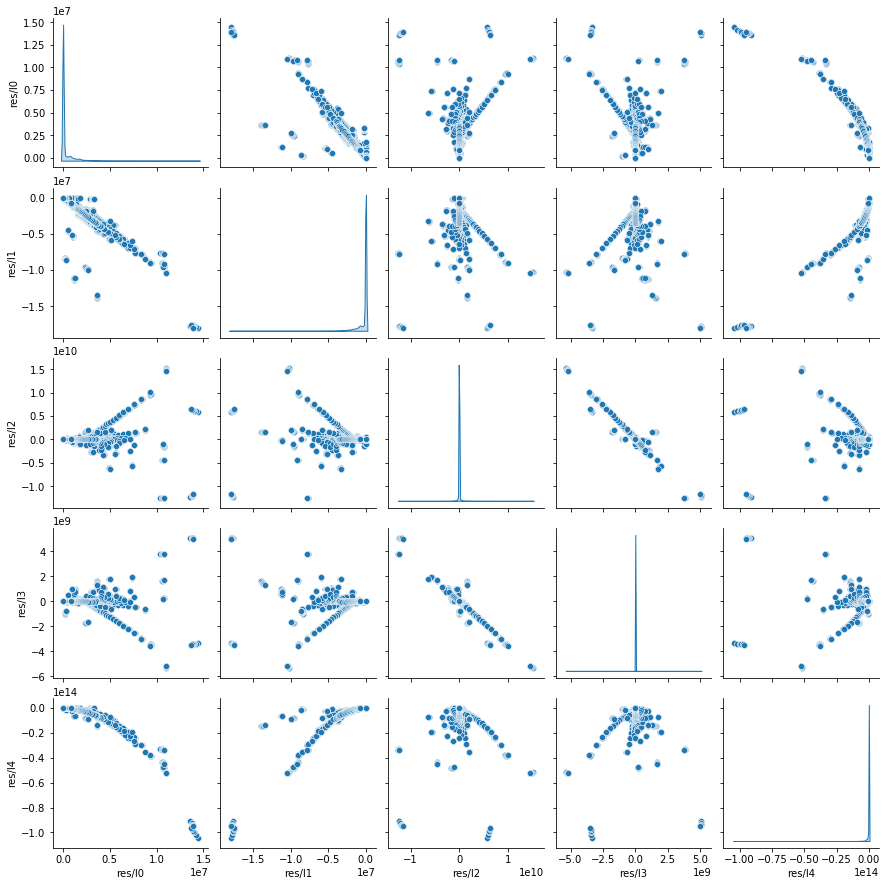

In [18]:
sns.pairplot(trainData[['res/I0', 'res/I1', 'res/I2', 'res/I3', 'res/I4']], diag_kind='kde')

In [20]:
trainData['res/I2']

0        -2.340748e+09
1         6.613434e+08
2        -6.261499e+08
3        -1.020359e+08
4        -7.138733e+07
              ...     
164995    2.737464e+07
164996    2.765813e+07
164997    2.799139e+07
164998    2.833061e+07
164999    2.839984e+07
Name: res/I2, Length: 165000, dtype: float64

In [22]:
trainData[trainData['res/I2']>0]['res/I2']

1         6.613434e+08
49        2.554472e+04
51        2.210190e+08
63        8.276092e+03
64        1.143602e+04
              ...     
164995    2.737464e+07
164996    2.765813e+07
164997    2.799139e+07
164998    2.833061e+07
164999    2.839984e+07
Name: res/I2, Length: 54480, dtype: float64

In [23]:
trainData['log_res/I0'] = np.log10(trainData['res/I0'])
trainData['log_res/I1'] = np.log10(-trainData['res/I1'])
trainData['log_plus_res/I2'] = np.log10(trainData[trainData['res/I2']>0]['res/I2'])
trainData['log_minus_res/I2'] = np.log10(-trainData[trainData['res/I2']<0]['res/I2'])
trainData['log_plus_res/I3'] = np.log10(trainData[trainData['res/I3']>0]['res/I3'])
trainData['log_minus_res/I3'] = np.log10(-trainData[trainData['res/I3']<0]['res/I3'])
trainData['log_res/I4'] = np.log10(-trainData['res/I4'])

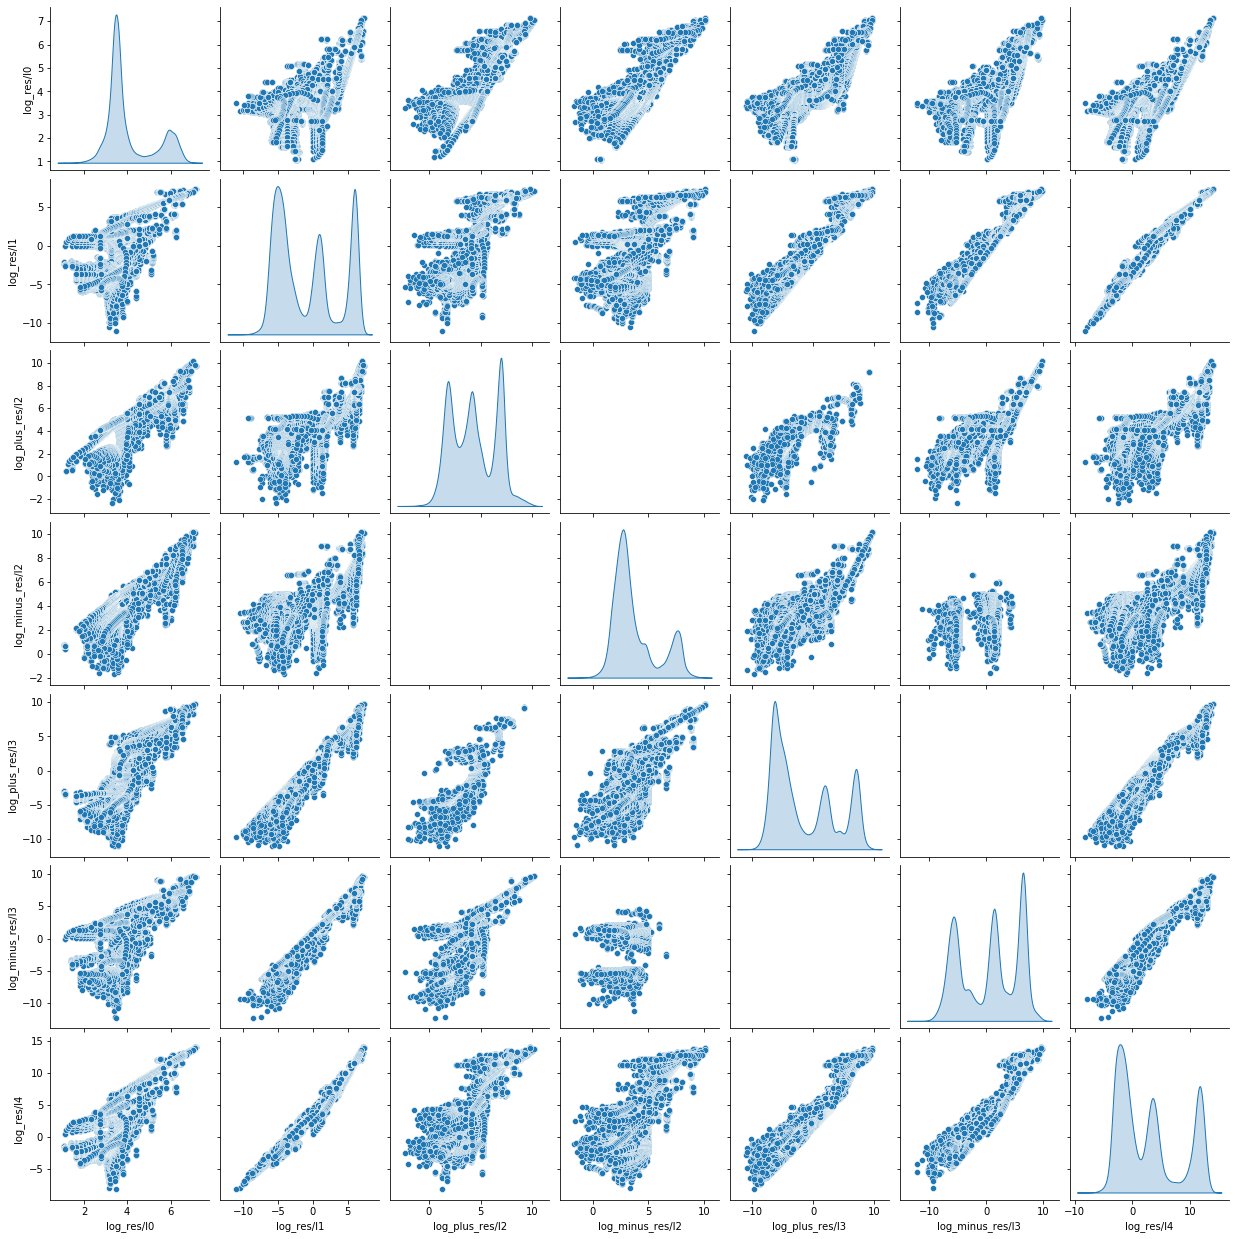

In [24]:
sns.pairplot(trainData[['log_res/I0', 'log_res/I1', 'log_plus_res/I2', 'log_minus_res/I2', \
                        'log_plus_res/I3', 'log_minus_res/I3', 'log_res/I4']], diag_kind='kde')

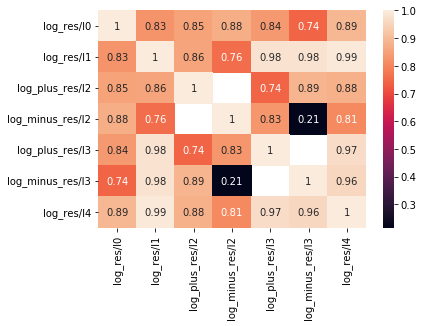

In [25]:
sns.heatmap(trainData[['log_res/I0', 'log_res/I1', 'log_plus_res/I2', 'log_minus_res/I2', \
                        'log_plus_res/I3', 'log_minus_res/I3', 'log_res/I4']].corr(), annot = True)

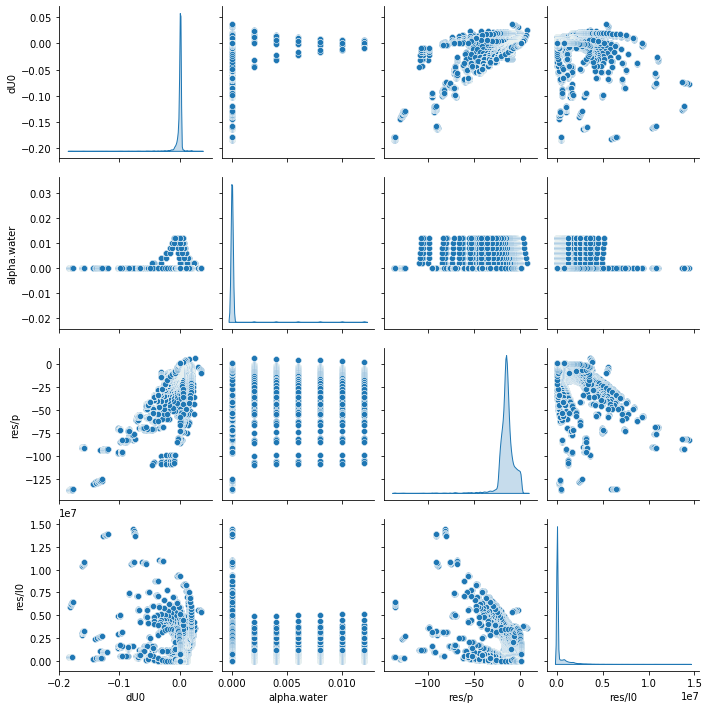

In [9]:
sns.pairplot(trainData[['dU0', 'alpha.water', 'res/p', 'res/I0']], diag_kind='kde')

In [ ]:
#testData = formDataset(testTSL, folder, FsScalars, FsVectors, FsTensors, size)

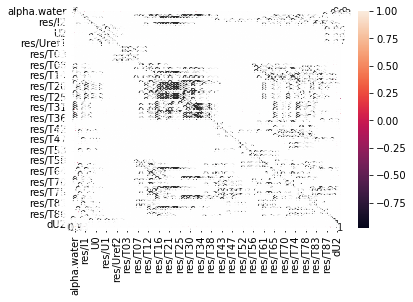

In [9]:
sns.heatmap(trainData.corr(), annot = True)